In [5]:
import sys
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import copy
from astropy.io import ascii
import plot_util
import sncosmo
import scipy
import nestle,corner,pickle
from scipy.stats import rv_continuous,gaussian_kde,norm as normal
import astropy.cosmology as cosmo
import matplotlib.gridspec as gridspec


In [51]:
data=ascii.read('snRequiem.dat')
models=ascii.read('lens_models.dat')
data['mag']=-2.5*np.log10(data['flux'])+data['zp']
data['magerr']=1.0857*data['fluxerr']/data['flux']
im0=data[data['id']==0]
im1=data[data['id']==1]
im2=data[data['id']==2]
models=models[models['MODEL']!='SN.4']
zp=23.9
cosmology=cosmo.FlatLambdaCDM(Om0=.3,H0=70)
#cosmology=cosmo.FlatLambdaCDM(Om0=.3,H0=74)
print(data)
print(models)

  time    band psf_flux apcorr ... dtC        mag                 magerr       
-------- ----- -------- ------ ... --- ------------------ ---------------------
57588.03 f105w   0.1748  1.192 ...  83 25.690616541668682   0.08868621227887617
57588.03 f105w   2.3471  1.192 ... 160 22.831000752687828 0.0064897821944932205
57588.03 f105w   0.0877  1.192 ...   0  26.10599327077479   0.13664416475972543
57587.97 f160w   1.1265  1.262 ...  83  23.65981158478723   0.03846420327027894
57587.97 f160w   3.5715  1.262 ... 160 22.414737160532887  0.012522842083821359
57587.97 f160w   0.6113  1.262 ...   0 24.334488941251866   0.07014444941808415
MODEL image   MU   ERR_MU TDELAY
----- ----- ------ ------ ------
    C  SN.1  6.879  0.527    0.0
    C  SN.2  9.526  1.075   97.6
    C  SN.3  6.324  0.496  -82.7
    C  SN.4    0.8  0.117 7320.1
    D  SN.1  7.472  0.629    0.0
    D  SN.2  9.923  1.202   99.1
    D  SN.3  6.281  0.527  -85.3
    D  SN.4   0.86  0.137 6949.6
    E  SN.1 13.257  2.709    0

In [7]:
class skewed_normal(rv_continuous):
    "Skewed Normal Distribution"
    def _pdf(self,x,mu,left_sigma,right_sigma):
        try:
            mu=list(mu)[0]
            left_sigma=list(left_sigma)[0]
            right_sigma=list(right_sigma)[0]
        except:
            pass

        left=normal(loc=mu,scale=left_sigma)
        right=normal(loc=mu,scale=right_sigma)
        pdf=np.piecewise(x,[x<mu,x>=mu],
                         [lambda y : scipy.stats.norm.pdf(
                            y, 
                            loc = mu, 
                            scale = left_sigma)/np.max(left.pdf(y)),
                          lambda y : scipy.stats.norm.pdf(
                                    y, 
                                    loc = mu, 
                                    scale = right_sigma)/np.max(right.pdf(y))])
        return(pdf/scipy.integrate.simps(pdf,x))

def _param_from_dist(dist):
    a=np.min(dist)-abs(np.min(dist))
    b=np.max(dist)+abs(np.max(dist))
    pdf=gaussian_kde(dist.T)#.pdf(np.arange(a,b,.001))
    return(pdf)#/scipy.integrate.simps(pdf))
def bounds_to_ppf(bounds):
    ppfs={}
    for key in bounds.keys():
        a,b=bounds[key]
        f = sncosmo.utils.Interp1D(0., 1., np.array([a, b]))
        ppfs[key]=f
    return ppfs

def prior_transform(nested_parameters):
        actual_parameters = np.empty(n_varied_parameter_dim, dtype=np.float)
        for i in range(n_varied_parameter_dim):
            actual_parameters[i] = ppfs[varied_param_names[i]](nested_parameters[i])
        return actual_parameters
class posterior(rv_continuous):
    "Skewed Normal Distribution"
    def _pdf(self,x,samples,weights):
        pdf,edges=np.histogram(samples,weights=weights,
                               bins=20,density=True)
        func=scipy.interpolate.interp1d([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)],
                                       pdf,fill_value=0,bounds_error=False)
        return(func(x))

    def _argcheck(self,*args):
        return True

def nice_corner(sample_result,color='k'):
    fig = corner.corner(
            sample_result.samples,
            weights=sample_result.weights,
            labels=["Age Image 1","Age Image 2","Age Image 3", "c","$M_B$"],
            quantiles=(0.16,.5, 0.84),
            bins = 30,\
           color=color,\
           show_titles=True,\
           title_fmt = '.2f',\
           smooth1d=False,\
           smooth=True,\
           fill_contours=True,\
           plot_contours =True,\
           plot_density=True,\
           use_mathtext=True,
           title_kwargs={"fontsize": 11},
           label_kwargs={'fontsize':16})
    for ax in fig.get_axes():
        ax.tick_params(axis='both',labelsize=14)
    return(fig,ax)

def calc_ev(res,nlive):
    logZnestle = res.logz                         # value of logZ
    infogainnestle = res.h                        # value of the information gain in nats
    logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

    # output marginal likelihood
    print('Marginalised evidence is {} ± {}'.format(logZnestle, logZerrnestle))
    
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)
parameter_bounds={'c':(-.3,.5)}

c_lims=[-0.300 , 0.500]
c_peak=[-0.054]
c_sigmas=[0.043 , 0.101]     # bifurcated sigmas
dist_c = skewed_normal('c',a=c_lims[0],b=c_lims[1])
logc_pdf=scipy.interpolate.interp1d(np.linspace(-0.300 , 0.500,1000),
                np.log(dist_c._pdf(np.linspace(-0.300 , 0.500,1000),
                c_peak,c_sigmas[0],c_sigmas[1])),fill_value=-np.inf,bounds_error=False)



logMb_prior=lambda x:np.log(scipy.stats.norm.pdf(
                x, 
                loc = -19.365, 
                scale = .47))

/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/nestle.py:905: RuntimeWarning: invalid value encountered in double_scalars
  h = (math.exp(logwt - logz_new) * active_logl[worst] +
<ipython-input-22-cb8b9460636b>:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('corner_color_curve_fit_with_c_prior.pdf',format='pdf',overwrite=True)


Marginalised evidence is -4.723326106645231 ± nan


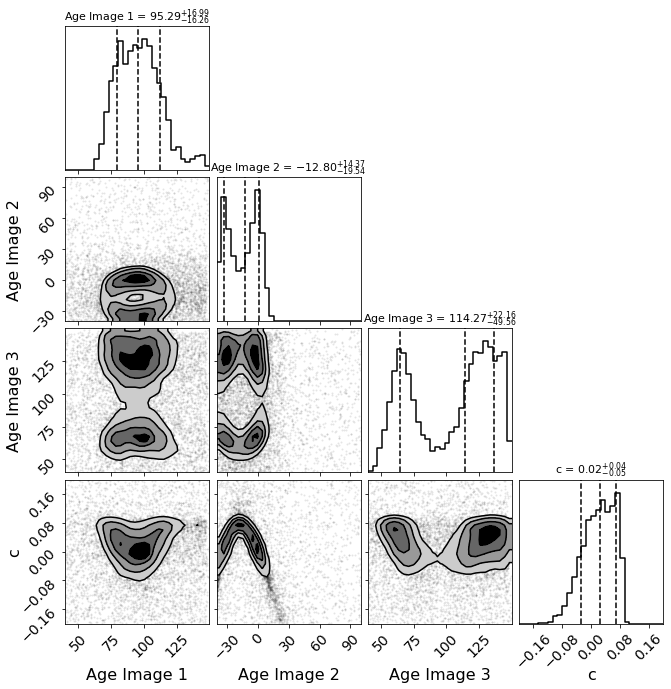

In [22]:
#Define the required functions for the mcmc tools:

dust = sncosmo.CCM89Dust()
model=sncosmo.Model('salt2-extended',effects=[dust],
                       effect_names=['mw'],
                       effect_frames=['obs'])
model.set(**{'z':1.9459,'mwebv':.014,'t0':0,'x1':0})

#t0,t1,t2 are age of image id=0,1,2
varied_param_names = ['t0','t1','t2','c']

#full range bounds first, then tightened
#parameter_bounds={'c':(-.3,.5),'t0':(-45,time[-1]),
#                  't1':(-45,time[-1]),'t2':(-45,time[-1]),'Mb':(-17,-20.8)}
parameter_bounds={'c':(-.2,.2),'t2':(40,150),
                  't1':(-40,100),'t0':(40,150),'Mb':(-18,-22)}

log_parameter_priors={'c':logc_pdf,'Mb':logMb_prior}

n_varied_parameter_dim = len(varied_param_names) 
n_live_points=1000
ppfs=bounds_to_ppf(parameter_bounds)


image_colors=np.array([im['mag'][np.where(im['band']=='f105w')[0][0]]-\
             im['mag'][np.where(im['band']=='f160w')[0][0]] for im in [im0,im1,im2]])
image_color_errs=np.array([np.sqrt(np.sum(im['magerr']**2)) for im in [im0,im1,im2]])

def age_priors(parameters):
    if np.all([-45<x<150 for x in parameters]):
        return 0.0
    else:
        return -np.inf
def c_uniform(c):
    if -.3<c<.5:
        return 0.0
    else:
        return -np.inf
def chisq_likelihood(parameters): 
    model.set(c=parameters[-1])
    chisq=0
    model_observations = model.color('F105W','F160W','ab',parameters[:3])
    chisq+=np.sum((image_colors-model_observations)**2/(image_color_errs**2))
    return chisq
def lnprob(parameters):
    #priorc=c_uniform(parameters[-1]) #for uniform priors
    priorc=log_parameter_priors['c'](parameters[-1]) #for prior based on existing distributions
    age_p=age_priors(parameters[:3]) #uniform priors on age based on bounds

    if not np.isfinite(priorc) or not np.isfinite(age_p):
        return -np.inf
    
    chisq=chisq_likelihood(parameters)
    if not np.isfinite(chisq):
        return -np.inf
    return(age_p+priorc-.5*chisq)

csample_result = nestle.sample(
    lnprob, 
    prior_transform, 
    n_varied_parameter_dim,
    npoints=n_live_points, 
    maxiter=None,
    maxcall=None
    )

nice_corner(csample_result)
plt.savefig('corner_color_curve_fit_with_c_prior.pdf',format='pdf',overwrite=True)
calc_ev(csample_result,n_live_points)
pickle.dump(csample_result,open('colorcurve_constraint.pkl','wb'))
plt.show()


Marginalised evidence is -5.126401707337832 ± 0.055622640338896606


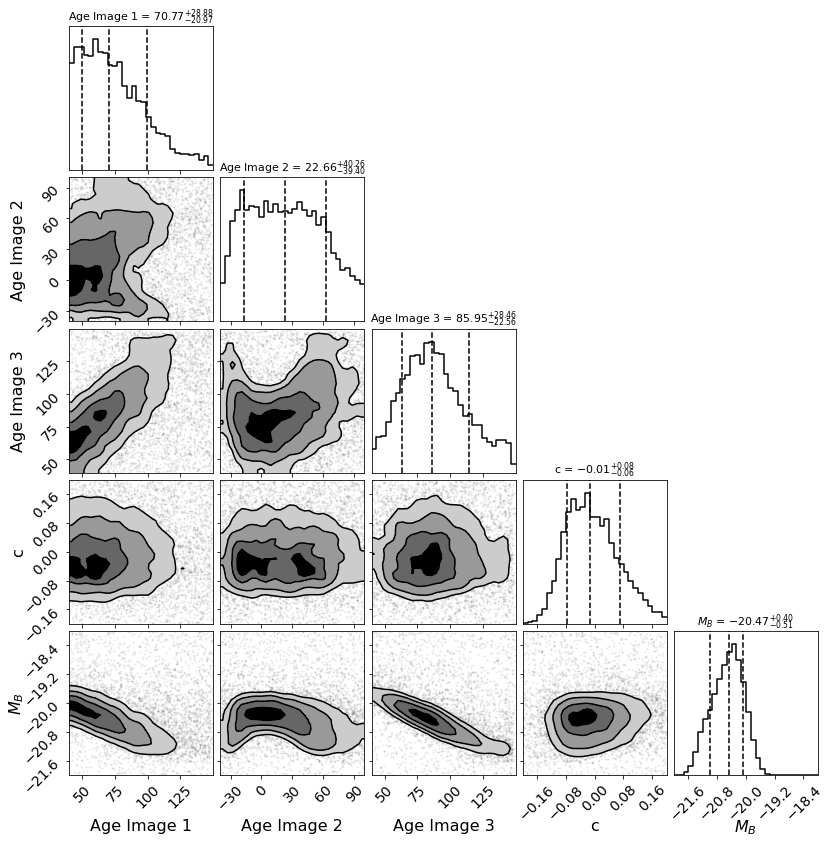

In [20]:
#Define the required functions for the mcmc tools:
dust = sncosmo.CCM89Dust()
model=sncosmo.Model('salt2-extended',effects=[dust],
                       effect_names=['mw'],
                       effect_frames=['obs'])
model.set(**{'z':1.9459,'mwebv':.014,'t0':0,'x1':0})
use_cfit_for_prior=False
lens_models_to_fit=['H']
#t0,t1,t2 are age of image id=0,1,2
varied_param_names = ['t0','t1','t2','c','Mb']
modelcov=True
#full range bounds first, then tightened
#parameter_bounds={'c':(-.3,.5),'t0':(-45,time[-1]),
#                  't1':(-45,time[-1]),'t2':(-45,time[-1]),'Mb':(-17,-20.8)}
parameter_bounds={'c':(-.2,.2),'t2':(40,150),
                  't1':(-40,100),'t0':(40,150),'Mb':(-18,-22)}

n_varied_parameter_dim = len(varied_param_names) 
n_live_points=1000
ppfs=bounds_to_ppf(parameter_bounds)

#logMb_prior=lambda x:0
logMb_prior=lambda x:np.log(scipy.stats.norm.pdf(
                 x, 
                 loc = -19.365, 
                 scale = 1))
# logMb_prior=lambda x:np.log(scipy.stats.norm.pdf(
#                 x, 
#                 loc = -20.5, 
#                 scale = .2))
log_parameter_priors={'c':logc_pdf,'Mb':logMb_prior}
all_mods={}
if use_cfit_for_prior:
    cfit_res=pickle.load(open('colorcurve_constraint.pkl','rb'))
    cfit_priors={}
    for i in range(4):
        if i<3:
            test=posterior('test',-45,145)
            cfit_priors[i]=scipy.interpolate.interp1d(np.arange(-50,150,.1),
                                                      np.log(test._pdf(np.arange(-50,150,.1),
                                                                       cfit_res.samples[:,i],
                                                                      cfit_res.weights)),
                                                     fill_value=-np.inf,bounds_error=False)
    
        else:
            test=posterior('test',-.2,.2)
            cfit_priors[i]=scipy.interpolate.interp1d(np.arange(-.2,.2,.001),
                                                      np.log(test._pdf(np.arange(-.2,.2,.001),
                                                                       cfit_res.samples[:,i],
                                                                      cfit_res.weights)),
                                                     fill_value=-np.inf,bounds_error=False)
else:
    cfit_priors=None

for lens_model in lens_models_to_fit:
    temp_lens=models[models['MODEL']==lens_model]
    flux_vals={}
    flux_errs={}
    for b in ['F160W']:
        flux_vals[b]=[]
        flux_errs[b]=[]
        for im in [im0,im1,im2]:
            mu=temp_lens['MU'][temp_lens['image']=='SN.'+str(im['id'][0]+1)]
            muerr=temp_lens['ERR_MU'][temp_lens['image']=='SN.'+str(im['id'][0]+1)]
            b_ind=np.where(im['band']==b.lower())[0][0]
            flux_err2=(im['flux'][b_ind]/mu)*np.sqrt((im['fluxerr'][b_ind]/im['flux'][b_ind])**2+\
                                               (muerr/mu)**2)
            flux_vals[b].append(im['flux'][b_ind]/mu)
            flux_errs[b].append(flux_err2)
        flux_vals[b]=np.array(flux_vals[b]).flatten()
        flux_errs[b]=np.array(flux_errs[b]).flatten()
    
    
    
    def age_priors(parameters):
        if np.all([-45<x<150 for x in parameters]):
            return 0.0
        else:
            return -np.inf
    
    def chisq_likelihood(parameters): 
        model.set_source_peakabsmag(parameters[-1],'bessellb','ab',cosmo=cosmology)
        model.set(c=parameters[-2])
        chisq=0
        
        
        for b in ['F160W']:
            model_observations = model.bandflux(b,parameters[:3],zp=zp,zpsys='ab')
            
            if modelcov:
                cov = np.diag(flux_errs[b]**2)
                _, mcov = model.bandfluxcov(b, parameters[:3],
                                            zp=zp, zpsys='ab')
                
                cov = cov + mcov
                invcov = np.linalg.pinv(cov)
            
                diff = flux_vals[b]-model_observations
                chisq+=np.dot(np.dot(diff, invcov), diff)
                
            else:
                chisq+=np.sum((flux_vals[b]-model_observations)**2/(flux_errs[b]**2))
        
        return chisq
    
    def lnprob(parameters):
        priorMb=log_parameter_priors['Mb'](parameters[-1])
        if cfit_priors is not None:
            c_age_priors=np.sum([cfit_priors[j](parameters[j]) for j in range(4)])
        else:
            #priorc=c_uniform(parameters[-1]) #for uniform priors
            priorc=log_parameter_priors['c'](parameters[-2]) #for prior based on existing distributions
            age_p=age_priors(parameters[:3]) #uniform priors on age based on bounds
            c_age_priors=priorc+age_p
        chisq=chisq_likelihood(parameters)
        if not np.isfinite(c_age_priors) or not np.isfinite(priorMb) or not np.isfinite(chisq):
            return -np.inf
        
        return(c_age_priors+priorMb-.5*chisq)

    sample_result_lc = nestle.sample(
        lnprob, 
        prior_transform, 
        n_varied_parameter_dim,
        npoints=n_live_points, 
        maxiter=None,
        maxcall=None
        )

    nice_corner(sample_result_lc)
    calc_ev(sample_result_lc,n_live_points)
    #pickle.dump(sample_result_lc,open('my_lightcurve_nestle.pkl','wb'))
    plt.savefig('lc_modelH_color_corner.pdf',format='pdf')
    plt.show()
    all_mods[lens_model]=sample_result_lc
    if not use_cfit_for_prior:
        pickle.dump(sample_result_lc,open('lc_model%s_constraint.pkl'%lens_model,'wb'))
    else:
        pickle.dump(sample_result_lc,open('lc_model%s_color_constraint.pkl'%lens_model,'wb'))

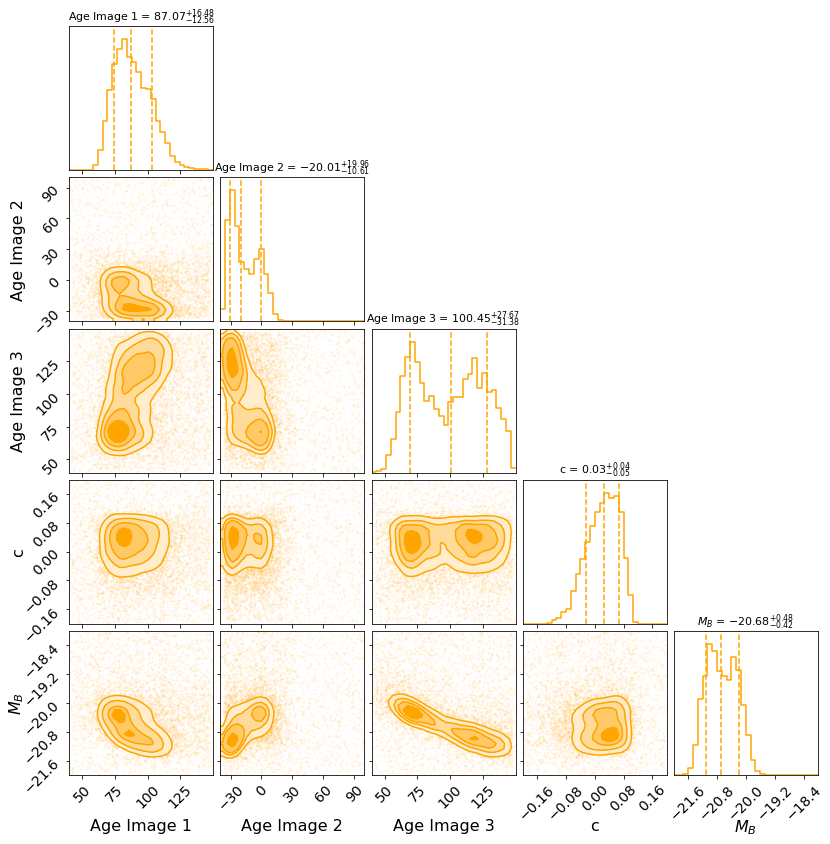

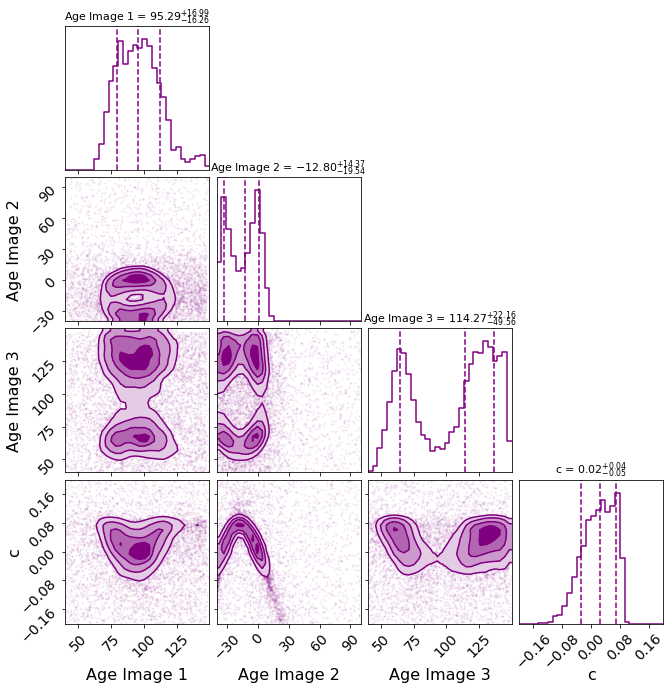

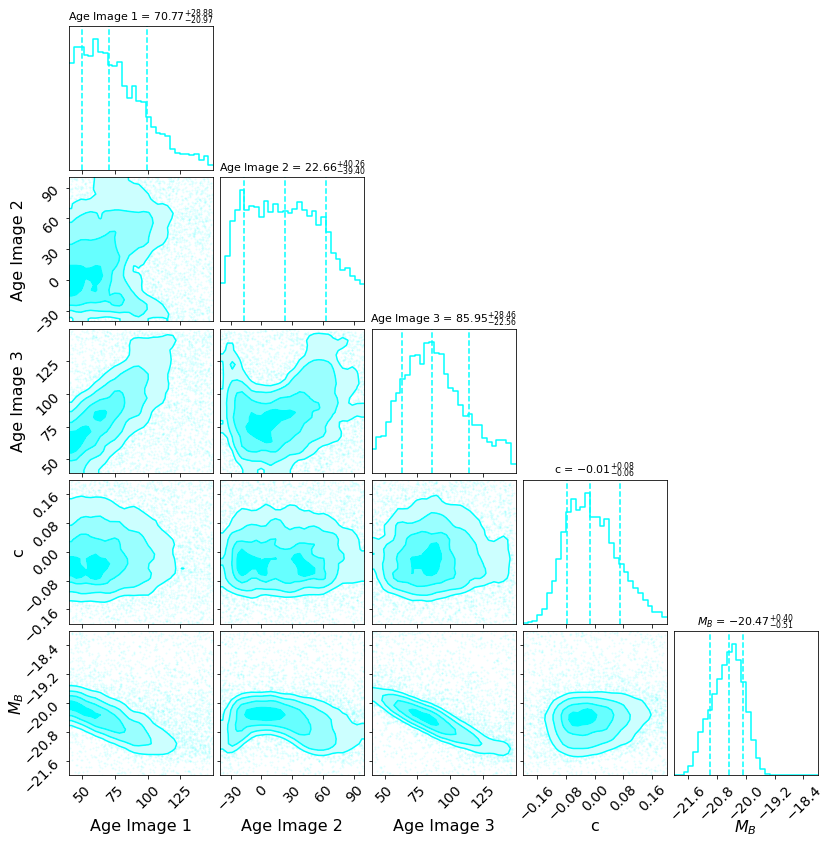

In [21]:
mod_result=pickle.load(open('lc_modelH_constraint.pkl','rb'))
bestMod_cfit=pickle.load(open('lc_modelH_color_constraint.pkl','rb'))
# temp_samples=copy.deepcopy(bestMod_cfit.samples)
# temp_samples[:,0]=copy.deepcopy(bestMod_cfit.samples[:,2])
# temp_samples[:,2]=copy.deepcopy(bestMod_cfit.samples[:,0])
# bestMod_cfit.samples=temp_samples
fig,ax=nice_corner(bestMod_cfit,color='orange')
# x=-2.8
# y=5.25
# ax.annotate('Combined Constraints',(-1.9,y),xycoords='axes fraction',fontsize=22)
# ax.annotate('Assumed Cosmology:',(x,y-.2),xycoords='axes fraction',fontsize=18)
# ax.annotate('Observations:',(x,y-.4),xycoords='axes fraction',fontsize=18)
# ax.annotate('SN model Priors:',(x,y-.6),xycoords='axes fraction',fontsize=18)
# ax.annotate('Lens Model Constraints:',(x,y-.8),xycoords='axes fraction',fontsize=18)
# ax.annotate(r'$f\Lambda$CDM, $H_0=70,\Omega_m=0.3$',(x+1.65,y-.2),
#             xycoords='axes fraction',fontsize=18,color='orange')
# ax.annotate('F105W-F160W Color',(x+.9,y-.4),xycoords='axes fraction',fontsize=16)
# ax.annotate('F105W,F160W Magnitude',(x+2.23,y-.4),xycoords='axes fraction',fontsize=16,color='orange')
# ax.annotate('SALT2-$c,x_1$',(x+1.33,y-.6),xycoords='axes fraction',fontsize=18)
# ax.annotate('$M_{B,pk}$',(x+3.32,y-.6),xycoords='axes fraction',fontsize=18,color='orange')
# ax.annotate(r'$\mu_1,\mu_2,\mu_3$',(x+3.1,y-.8),xycoords='axes fraction',fontsize=18,color='orange')
plt.savefig('lc_modelH_color_corner_labels.pdf',format='pdf')
plt.show()
cnest_noprior=pickle.load(open('colorcurve_constraint_noprior.pkl','rb'))
cnest_prior=pickle.load(open('colorcurve_constraint.pkl','rb'))
#switch images 1 and 3--color
# temp_samples=copy.deepcopy(cnest_prior.samples)
# temp_samples[:,0]=copy.deepcopy(cnest_prior.samples[:,2])
# temp_samples[:,2]=copy.deepcopy(cnest_prior.samples[:,0])
# cnest_prior.samples=temp_samples
fig,ax=nice_corner(cnest_prior,color='purple')

# x=-2
# y=4.15
# ax.annotate('Color Curve-based Constraints',(-1.2,y),xycoords='axes fraction',fontsize=20)
# ax.annotate('Assumed Cosmology:',(x,y-.2),xycoords='axes fraction',fontsize=16)
# ax.annotate('Observations:',(x,y-.4),xycoords='axes fraction',fontsize=16)
# ax.annotate('SN model Priors:',(x,y-.6),xycoords='axes fraction',fontsize=16)
# ax.annotate('Lens Model Constraints:',(x,y-.8),xycoords='axes fraction',fontsize=16)
# ax.annotate(r'$f\Lambda$CDM, $H_0=70,\Omega_m=0.3$',(x+1.35,y-.2),
#             xycoords='axes fraction',fontsize=16,color='purple')
# ax.annotate('F105W-F160W Color',(x+.8,y-.4),xycoords='axes fraction',fontsize=16,color='purple')
# ax.annotate('F160W Magnitude',(x+2.03,y-.4),xycoords='axes fraction',fontsize=16)
# ax.annotate('SALT2-$c,x_1$',(x+1.3,y-.6),xycoords='axes fraction',fontsize=16,color='purple')
# ax.annotate('$M_{B,pk}$',(x+2.76,y-.6),xycoords='axes fraction',fontsize=16)
# ax.annotate(r'$\mu_1,\mu_2,\mu_3$',(x+2.56,y-.8),xycoords='axes fraction',fontsize=16)

plt.savefig('corner_color_curve_fit_with_c_prior_labels.pdf',format='pdf')
plt.show()
#switch images 1 and 3--light
# temp_samples=copy.deepcopy(mod_result.samples)
# temp_samples[:,0]=copy.deepcopy(mod_result.samples[:,2])
# temp_samples[:,2]=copy.deepcopy(mod_result.samples[:,0])
# mod_result.samples=temp_samples
fig,ax=nice_corner(mod_result,color='cyan')
# x=-2.8
# y=5.25
# ax.annotate('Light Curve-based Constraints',(-1.9,y),xycoords='axes fraction',fontsize=22)
# ax.annotate('Assumed Cosmology:',(x,y-.2),xycoords='axes fraction',fontsize=18)
# ax.annotate('Observations:',(x,y-.4),xycoords='axes fraction',fontsize=18)
# ax.annotate('SN model Priors:',(x,y-.6),xycoords='axes fraction',fontsize=18)
# ax.annotate('Lens Model Constraints:',(x,y-.8),xycoords='axes fraction',fontsize=18)
# ax.annotate(r'$f\Lambda$CDM, $H_0=70,\Omega_m=0.3$',(x+1.65,y-.2),
#             xycoords='axes fraction',fontsize=18,color='orange')
# ax.annotate('F105W-F160W Color',(x+1.2,y-.4),xycoords='axes fraction',fontsize=16)
# ax.annotate('F160W Magnitude',(x+2.63,y-.4),xycoords='axes fraction',fontsize=16,color='orange')
# ax.annotate('SALT2-$c,x_1$',(x+1.63,y-.6),xycoords='axes fraction',fontsize=18)
# ax.annotate('$M_{B,pk}$',(x+3.32,y-.6),xycoords='axes fraction',fontsize=18,color='orange')
# ax.annotate(r'$\mu_1,\mu_2,\mu_3$',(x+3.1,y-.8),xycoords='axes fraction',fontsize=18,color='orange')
plt.savefig('lc_modelH_corner_labels.pdf',format='pdf')
plt.show()
plt.close()

In [9]:

legend_fontsize=24
axis_fontsize=30
ticksize=26

/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:1529: RuntimeWarning: invalid value encountered in subtract
  return (self.bandmag(band1, magsys, time) -
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:1529: RuntimeW

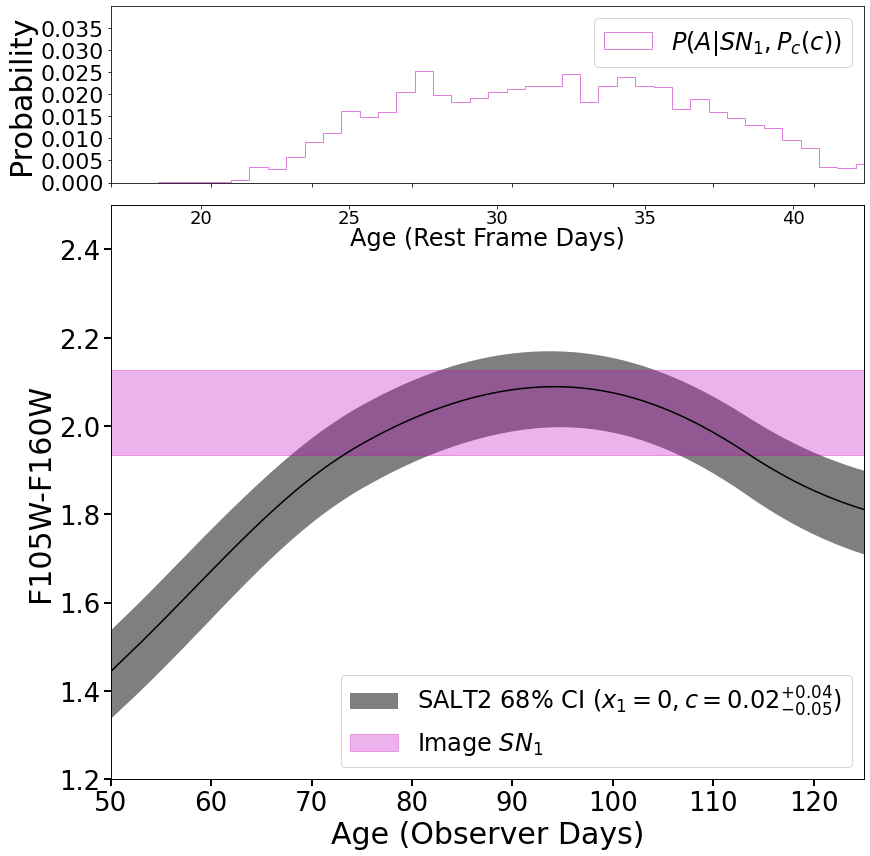

/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:1529: RuntimeWarning: invalid value encountered in subtract
  return (self.bandmag(band1, magsys, time) -
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:1529: RuntimeW

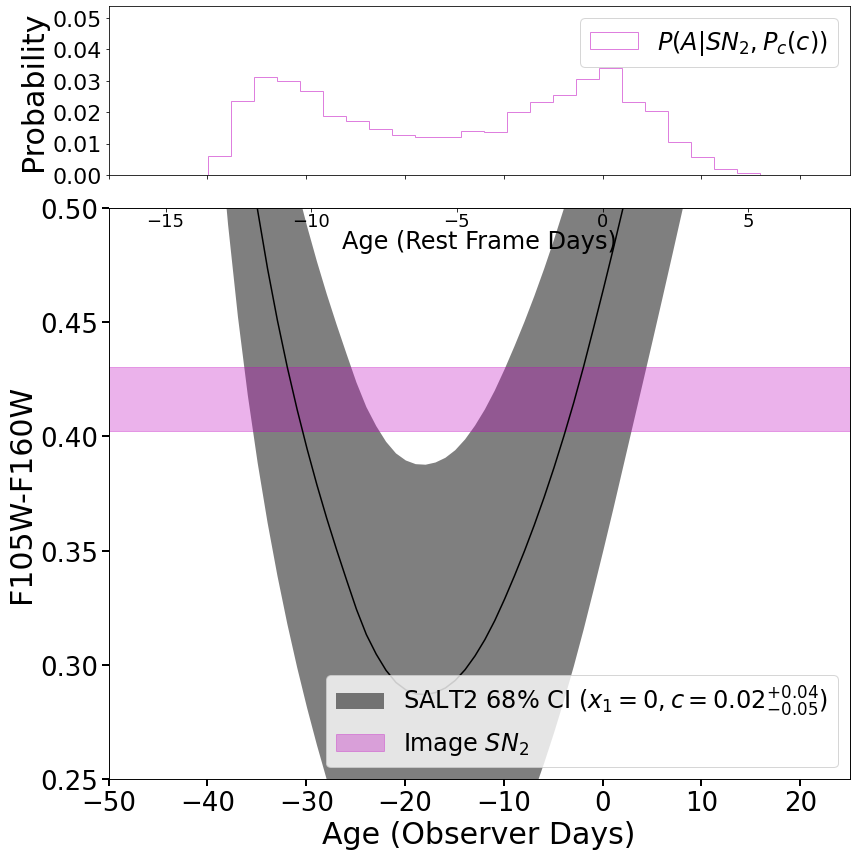

/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:1529: RuntimeWarning: invalid value encountered in subtract
  return (self.bandmag(band1, magsys, time) -
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/sncosmo/models.py:1529: RuntimeW

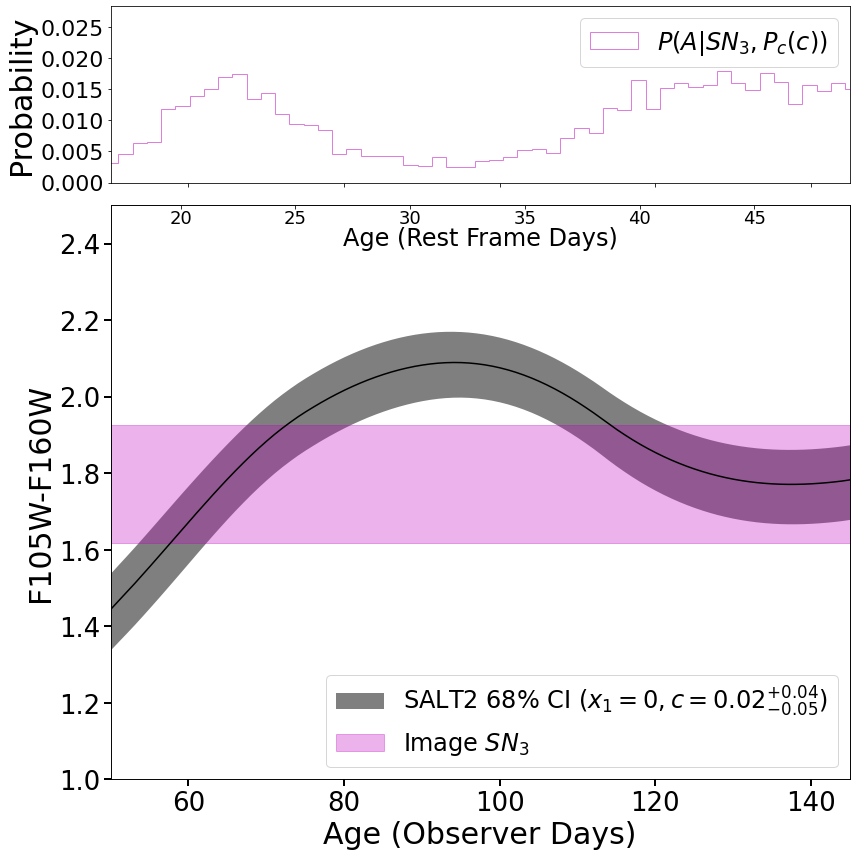

In [15]:
#make color curve fitting plots
dust = sncosmo.CCM89Dust()
model=sncosmo.Model('salt2-extended',effects=[dust],
                       effect_names=['mw'],
                       effect_frames=['obs'])
model.set(**{'z':1.9459,'mwebv':.014,'t0':0,'x1':0})
i=-1
cnest_prior=pickle.load(open('colorcurve_constraint.pkl','rb'))
#switch images 1 and 3
temp_samples=copy.deepcopy(cnest_prior.samples)
#temp_samples[:,0]=copy.deepcopy(cnest_prior.samples[:,2])
#temp_samples[:,2]=copy.deepcopy(cnest_prior.samples[:,0])
cnest_prior.samples=temp_samples
#nice_corner(sample_result_lc)
#plt.savefig('corner_color_curve_fit_with_c_prior.pdf',format='pdf',overwrite=True)
#plt.close()
#ylim_dict={0:(1,2.5),1:(.25,.5),2:(1.2,2.5)}
#xlim_dict={0:(50,145),1:(-50,25),2:(50,125)}
ylim_dict={2:(1,2.5),1:(.25,.5),0:(1.2,2.5)}
xlim_dict={2:(50,145),1:(-50,25),0:(50,125)}

t0, t1,t2,c = [weighted_quantile(cnest_prior.samples[:,i], .5, 
                                     sample_weight=cnest_prior.weights)\
                   for i in range(4)]
t0_16, t1_16,t2_16,c_16 = [weighted_quantile(cnest_prior.samples[:,i], .16, 
                                     sample_weight=cnest_prior.weights)\
                   for i in range(4)]
t0_84, t1_84,t2_84,c_84 = [weighted_quantile(cnest_prior.samples[:,i], .84, 
                                     sample_weight=cnest_prior.weights)\
                   for i in range(4)]
for im in [im0,im1,im2]:
    i+=1     

    plot_time=np.arange(model.mintime()-10,model.maxtime()+10,1)
    model.set(c=c)
    fig=plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(4, 4)
    #fig,gs=plot_util.grid_plot(4,4)
    ax_main=fig.add_subplot(gs[1:,:])
    
    ax_main=plot_util.plot('plot',plot_time,model.color('F105W','F160W','ab',plot_time),
                             ax=ax_main,x_lab='Age (Observer Days)',ticklabelsize=ticksize,
                             fontsize=axis_fontsize,
                             y_lab='F105W-F160W',color='k',alpha=1)
    plt.xlim(xlim_dict[i])
    ax_main_top=ax_main.twiny()
    ax_main_top.tick_params(direction='in',pad=-22)
    ax_main_top.tick_params(labelsize=18)
    ax_main_top.set_xlabel('Age (Rest Frame Days)',fontsize=axis_fontsize-6,labelpad=-40)
    ax_main_top.set_xlim((xlim_dict[i][0]/2.95,xlim_dict[i][1]/2.95))
    
    if i in ylim_dict.keys():
        plt.ylim(ylim_dict[i])
    
    model.set(c=c_16)
    min_cols=model.color('F105W','F160W','ab',plot_time)
    model.set(c=c_84)
    max_cols=model.color('F105W','F160W','ab',plot_time)
    ax_main.fill_between(plot_time,min_cols,max_cols,color='k',alpha=.5,linewidth=0,
            label='SALT2 68% CI'+' ($x_1=0,c=%.2f^{+%.2f}_{-%.2f})$'%(c,c_84-c,c-c_16))

    
    temp_color=im['mag'][np.where(im['band']=='f105w')[0][0]]-\
                 im['mag'][np.where(im['band']=='f160w')[0][0]]
    temp_col_err=np.sqrt(np.sum(im['magerr']**2))
    nbins=60
    ax_top=fig.add_subplot(gs[0,:],sharex=ax_main)
#     ax_top.hist(cnest_noprior.samples[:,i],weights=cnest_prior.weights,bins=nbins,density=True,
#                 label='$P(A|SN_'+str(i+1)+')$',
#                alpha=.5,histtype='step',color='c')
    ax_top.hist(cnest_prior.samples[:,i],weights=cnest_prior.weights,bins=nbins,
                density=True,label='$P(A|SN_'+str(i+1)+',P_c(c))$',alpha=.5,histtype='step',
                color='m')
    
    
    for tick in ax_top.xaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize-4)
    for tick in ax_top.yaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize-4)

    ax_top.legend(fontsize=legend_fontsize,loc='upper right')
    yvals=np.arange(np.nanmin(min_cols),np.nanmax(max_cols),.001)
    
    ax_top.label_outer()
    
    ax_top.set_ylabel('Probability',fontsize=axis_fontsize)
    ax_top.set_ylim((0,ax_top.get_ylim()[1]*1.5))
    
    ax_main.fill_between(plot_time,temp_color-temp_col_err,temp_color+temp_col_err,
                     color='m',alpha=.3,label='Image $SN_'+str(i+1)+'$')
    #ax_main.fill_between(plot_time,temp_color-2*temp_col_err,temp_color+2*temp_col_err,
    #                 color='c',alpha=.1,label='Image $SN_'+str(i+1)+'$ 95% CI')
    
    ax_main.legend(fontsize=legend_fontsize,loc='lower right')
    
    
    plt.tight_layout()
    plt.savefig('colorcurve_image%i.pdf'%(i+1),format='pdf',overwrite=True)
    plt.show()
    

<ipython-input-27-c3419e68852e>:70: RuntimeWarning: divide by zero encountered in log10
  -2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp,ax=ax_main,x_lab='Time (Observer Days)',
<ipython-input-27-c3419e68852e>:77: RuntimeWarning: divide by zero encountered in log10
  min_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
<ipython-input-27-c3419e68852e>:80: RuntimeWarning: divide by zero encountered in log10
  max_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
<ipython-input-27-c3419e68852e>:111: RuntimeWarning: divide by zero encountered in log10
  all_mag=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp


  time    band psf_flux apcorr ... dtC        mag                magerr      
-------- ----- -------- ------ ... --- ------------------ -------------------
57588.03 f105w   0.1748  1.192 ...  83 25.690616541668682 0.08868621227887617
57587.97 f160w   1.1265  1.262 ...  83  23.65981158478723 0.03846420327027894


<ipython-input-27-c3419e68852e>:159: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('lightcurve_image%i.pdf'%(i+1),format='pdf',overwrite=True)


<Figure size 432x288 with 0 Axes>

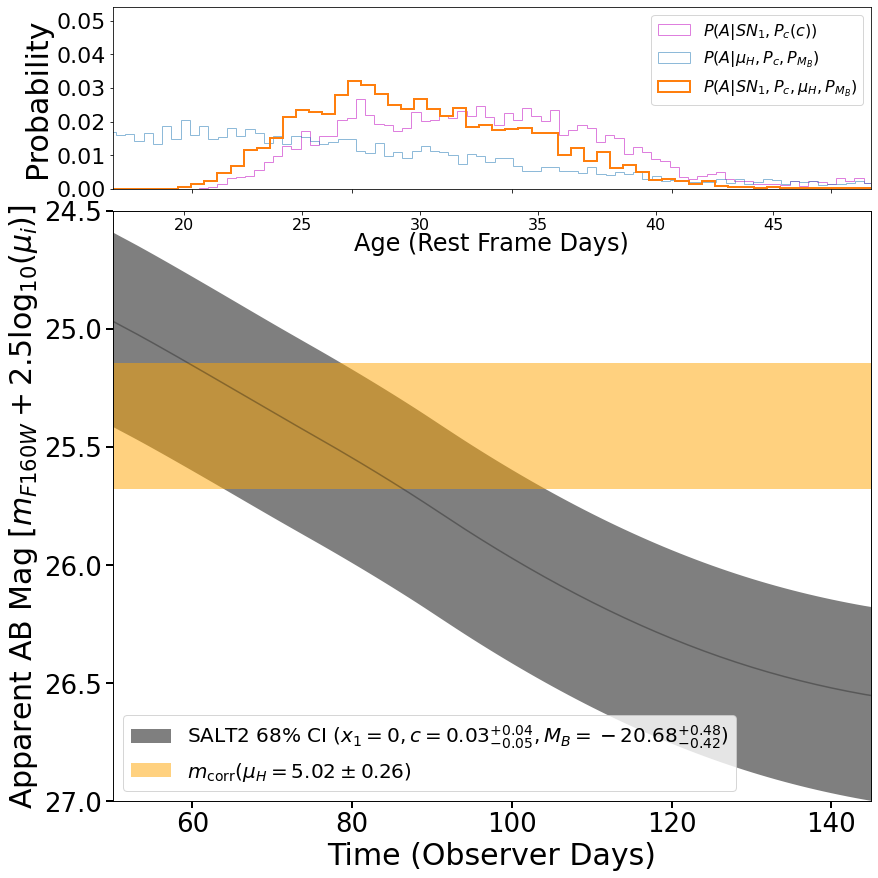

<ipython-input-27-c3419e68852e>:70: RuntimeWarning: divide by zero encountered in log10
  -2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp,ax=ax_main,x_lab='Time (Observer Days)',
<ipython-input-27-c3419e68852e>:77: RuntimeWarning: divide by zero encountered in log10
  min_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
<ipython-input-27-c3419e68852e>:80: RuntimeWarning: divide by zero encountered in log10
  max_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
<ipython-input-27-c3419e68852e>:111: RuntimeWarning: divide by zero encountered in log10
  all_mag=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp


  time    band psf_flux apcorr ... dtC        mag                 magerr       
-------- ----- -------- ------ ... --- ------------------ ---------------------
57588.03 f105w   2.3471  1.192 ... 160 22.831000752687828 0.0064897821944932205
57587.97 f160w   3.5715  1.262 ... 160 22.414737160532887  0.012522842083821359


<ipython-input-27-c3419e68852e>:159: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('lightcurve_image%i.pdf'%(i+1),format='pdf',overwrite=True)


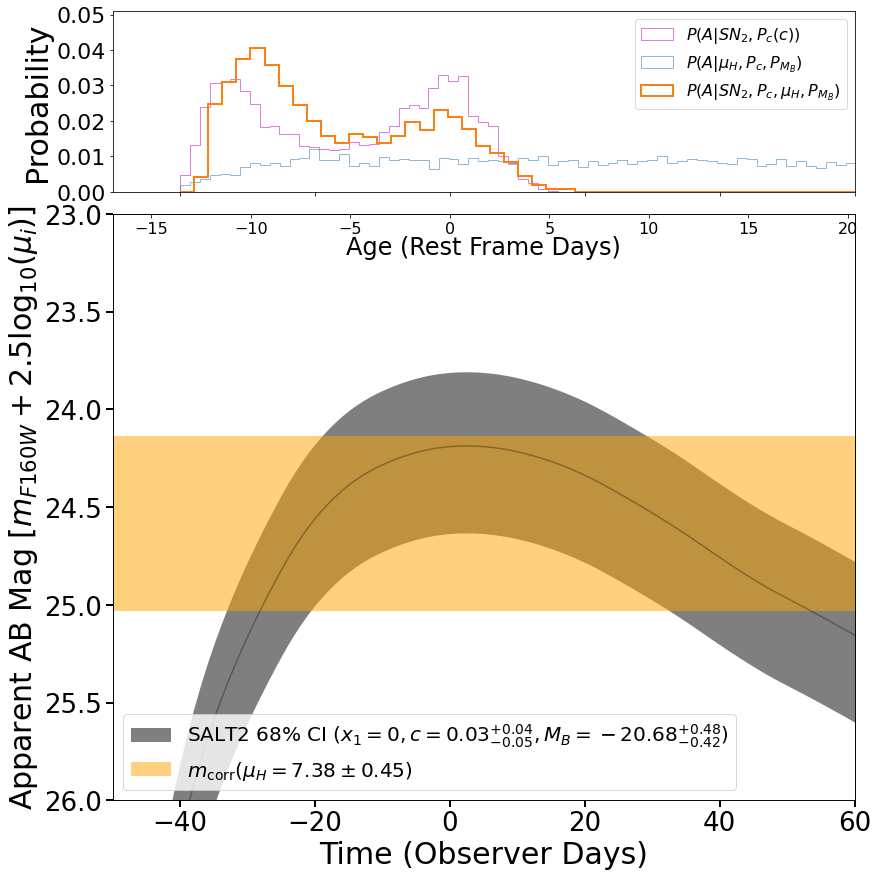

<ipython-input-27-c3419e68852e>:70: RuntimeWarning: divide by zero encountered in log10
  -2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp,ax=ax_main,x_lab='Time (Observer Days)',
<ipython-input-27-c3419e68852e>:77: RuntimeWarning: divide by zero encountered in log10
  min_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
<ipython-input-27-c3419e68852e>:80: RuntimeWarning: divide by zero encountered in log10
  max_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
<ipython-input-27-c3419e68852e>:111: RuntimeWarning: divide by zero encountered in log10
  all_mag=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp


  time    band psf_flux apcorr ... dtC        mag                magerr      
-------- ----- -------- ------ ... --- ------------------ -------------------
57588.03 f105w   0.0877  1.192 ...   0  26.10599327077479 0.13664416475972543
57587.97 f160w   0.6113  1.262 ...   0 24.334488941251866 0.07014444941808415


<ipython-input-27-c3419e68852e>:159: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('lightcurve_image%i.pdf'%(i+1),format='pdf',overwrite=True)


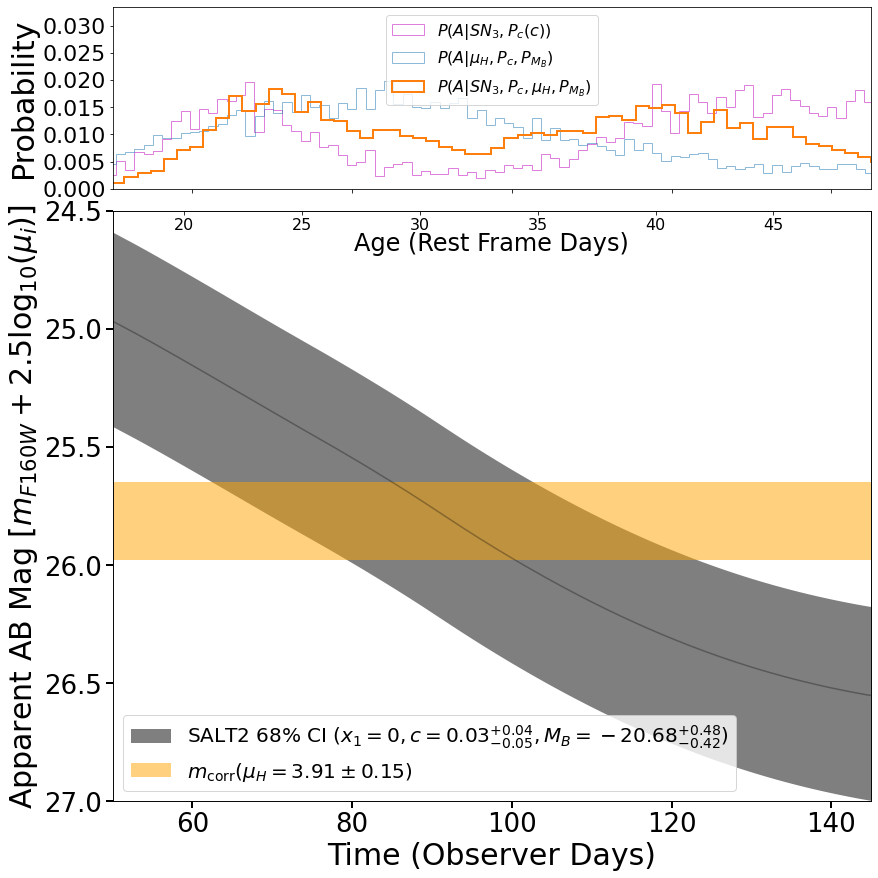

In [27]:
#make light curve fitting plots
plt.clf()
band='F160W'
dust = sncosmo.CCM89Dust()
model=sncosmo.Model('salt2-extended',effects=[dust],
                       effect_names=['mw'],
                       effect_frames=['obs'])
model.set(**{'z':1.9459,'mwebv':.014,'t0':0,'x1':0})

model.set_source_peakabsmag(-19.365,'bessellb','ab')

i=-1

ylim_dict={2:(24.5,27),1:(23,26),0:(24.5,27)}
xlim_dict={2:(50,145),1:(-50,60),0:(50,145)}
# ylim_dict={2:(26.5,28.5),1:(24,26),0:(26.5,29)}
# xlim_dict={2:(50,145),1:(-50,60),0:(50,145)}
mod_result=pickle.load(open('lc_modelH_constraint.pkl','rb'))
bestMod_cfit=pickle.load(open('lc_modelH_color_constraint.pkl','rb'))
#cnest_noprior=pickle.load(open('colorcurve_constraint_noprior.pkl','rb'))
cnest_prior=pickle.load(open('colorcurve_constraint.pkl','rb'))
#switch images 1 and 3--color
# temp_samples=copy.deepcopy(cnest_prior.samples)
# temp_samples[:,0]=copy.deepcopy(cnest_prior.samples[:,2])
# temp_samples[:,2]=copy.deepcopy(cnest_prior.samples[:,0])
# cnest_prior.samples=temp_samples
#switch images 1 and 3--light
# temp_samples=copy.deepcopy(mod_result.samples)
# temp_samples[:,0]=copy.deepcopy(mod_result.samples[:,2])
# temp_samples[:,2]=copy.deepcopy(mod_result.samples[:,0])
# mod_result.samples=temp_samples
# nice_corner(mod_result)
# plt.savefig('lc_modelH_corner.pdf')
# plt.close()
#switch images 1 and 3--combined
# temp_samples=copy.deepcopy(bestMod_cfit.samples)
# temp_samples[:,0]=copy.deepcopy(bestMod_cfit.samples[:,2])
# temp_samples[:,2]=copy.deepcopy(bestMod_cfit.samples[:,0])
# bestMod_cfit.samples=temp_samples
# nice_corner(bestMod_cfit)
# plt.savefig('lc_modelH_color_corner.pdf')
# plt.close()
best_model='H'
mod_result={best_model:mod_result}
quantile_dict={}
for q in [2.5,16,50,84,97.5]:
    t0, t1,t2,c,M_B = [weighted_quantile(bestMod_cfit.samples[:,i], q/100, 
                                     sample_weight=bestMod_cfit.weights)\
                   for i in range(5)]
    quantile_dict['t0_%s'%str(q)]=t0
    quantile_dict['t1_%s'%str(q)]=t1
    quantile_dict['t2_%s'%str(q)]=t2
    quantile_dict['c_%s'%str(q)]=c
    quantile_dict['M_B_%s'%str(q)]=M_B


for im in [im0,im1,im2]:
    i+=1 
    
    time=np.arange(model.mintime(),model.maxtime(),2)
    
    plot_time=np.arange(time[0]-10,time[-1]+10,1)
    model.set(c=quantile_dict['c_50'])
    model.set_source_peakabsmag(quantile_dict['M_B_50'],'bessellb','ab')
    fig=plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(4,4)
    #fig,axes,gs=plot_util.grid_plot(4,4)
    ax_main=fig.add_subplot(gs[1:,:])
    ax_main=plot_util.plot('plot',plot_time,
                -2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp,ax=ax_main,x_lab='Time (Observer Days)',
                y_lab=r'Apparent AB Mag [$m_{'+band+'}+2.5\log_{10}(\mu_i)$]',ticklabelsize=ticksize,
                             fontsize=axis_fontsize,color='k',alpha=.3)
    plt.ylim(ylim_dict[i])
    plt.xlim(xlim_dict[i])
    model.set(c=quantile_dict['c_16'])
    model.set_source_peakabsmag(quantile_dict['M_B_16'],'bessellb','ab')
    min_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    model.set(c=quantile_dict['c_84'])
    model.set_source_peakabsmag(quantile_dict['M_B_84'],'bessellb','ab')
    max_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    ax_main.fill_between(plot_time,min_cols,max_cols,color='k',alpha=.5,linewidth=0,
            label='SALT2 68%'+' CI ($x_1=0,c=%.2f^{+%.2f}_{-%.2f},M_B=%.2f^{+%.2f}_{-%.2f}$)'%\
                         (quantile_dict['c_50'],quantile_dict['c_84']-quantile_dict['c_50'],
                                quantile_dict['c_50']-quantile_dict['c_16'],
                                quantile_dict['M_B_50'],
                                quantile_dict['M_B_84']-quantile_dict['M_B_50'],
                                quantile_dict['M_B_50']-quantile_dict['M_B_16']))
    
    '''
    #add 95% contours
    model.set(c=quantile_dict['c_97.5'])
    model.set_source_peakabsmag(quantile_dict['M_B_97.5'],'bessellb','ab')
    min_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    model.set(c=quantile_dict['c_2.5'])
    model.set_source_peakabsmag(quantile_dict['M_B_2.5'],'bessellb','ab')
    max_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    ax_main.fill_between(plot_time,min_cols,max_cols,color='k',alpha=.2,linewidth=0,
                         label='SALT2 95% CI')
    '''
    
    mod_cols={'C':'b','D':'r','H':'orange','F':'r'}
    

    temp_lens=models[models['MODEL']==best_model]
    print(im)
    mu=temp_lens['MU'][temp_lens['image']=='SN.'+str(im['id'][0]+1)]
    muerr=1.0857*temp_lens['ERR_MU'][temp_lens['image']=='SN.'+str(im['id'][0]+1)]/mu
    b_ind=np.where(im['band']==band.lower())[0][0]
    magerr=1.0857*im['fluxerr'][b_ind]/im['flux'][b_ind]
    mag_err2=np.sqrt(magerr**2+muerr**2)
    all_mag=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    mod_mag=-2.5*np.log10(im['flux'][b_ind])+zp+2.5*np.log10(mu)
    ax_main.fill_between(plot_time,mod_mag+mag_err2,
                         mod_mag-mag_err2,linewidth=0,alpha=.5,
                         label=r'$m_{\rm{corr}}(\mu_'+best_model+'=%.2f\pm%.2f$)'%(mu,muerr),
                         color=mod_cols[best_model])
    

    

    ax_main.legend(fontsize=legend_fontsize-4,loc='lower left')
        
    ax_top=fig.add_subplot(gs[0,:],sharex=ax_main)
    
    nbins=95
    #ax_top.hist(cnest_noprior.samples[:,i],weights=cnest_noprior.weights,bins=nbins,density=True,label='$P(A|SN_'+str(i+1)+')$',
    #           alpha=.5,histtype='step',color='c')
    ax_top.hist(cnest_prior.samples[:,i],weights=cnest_prior.weights,bins=nbins,
                density=True,label='$P(A|SN_'+str(i+1)+',P_c(c))$',alpha=.5,
                histtype='step',color='m')
    

    ax_top.hist(mod_result[best_model].samples[:,i],weights=mod_result[best_model].weights,
                bins=nbins,density=True,label='$P(A|\mu_'+best_model+',P_c,P_{M_B})$',
               alpha=.5,histtype='step')

    ax_top.hist(bestMod_cfit.samples[:,i],weights=bestMod_cfit.weights,
                bins=int(nbins/1.4),
            density=True,label='$P(A|SN_'+str(i+1)+',P_c,\mu_'+best_model+',P_{M_B})$',alpha=1,
                histtype='step',linewidth=2)
    for tick in ax_top.xaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize-4)
    for tick in ax_top.yaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize-4)
    loc = 'upper right' if i!=2 else 'upper center'
    ax_top.legend(fontsize=legend_fontsize-8,loc=loc)
    ax_top.set_ylabel('Probability',fontsize=axis_fontsize)
    ax_top.label_outer()
    ax_main_top=ax_main.twiny()
    ax_main_top.tick_params(direction='in',pad=-22)
    ax_main_top.tick_params(labelsize=16)
    ax_main_top.set_xlabel('Age (Rest Frame Days)',fontsize=axis_fontsize-6,labelpad=-40)
    ax_main_top.set_xlim((xlim_dict[i][0]/2.95,xlim_dict[i][1]/2.95))
    ylim=ax_top.get_ylim()
    scale=1.6 if i!=1 else 1.2
    ax_top.set_ylim((ylim[0],ylim[1]*scale))
    plt.tight_layout(pad=0)
    ax_main.invert_yaxis()
    plt.savefig('lightcurve_image%i.pdf'%(i+1),format='pdf',overwrite=True)
    plt.show()

## 

-23.686527314203673 -105.74802091636629 24.956950793060642
-23.69905765857282 10.1941561677279 24.232026475096138


<ipython-input-30-1db2a7f07522>:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('time_delays.pdf',format='pdf',overwrite=True)


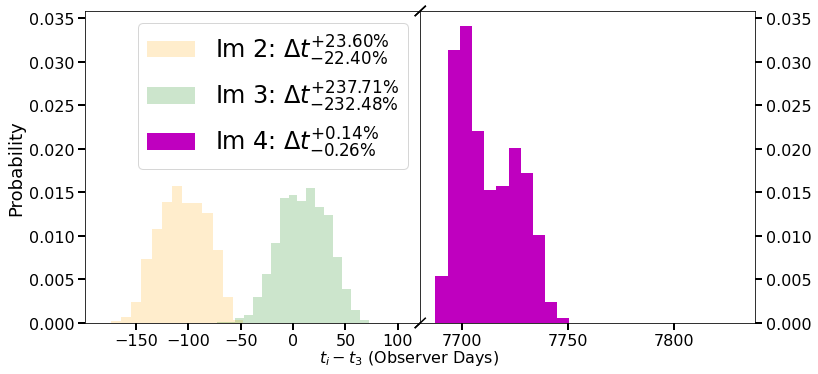

In [30]:
bestMod_cfit=pickle.load(open('lc_modelH_color_constraint.pkl','rb'))
quantile_dict={}
for q in [2.5,16,50,84,97.5]:
    t0, t1,t2,c,M_B = [weighted_quantile(bestMod_cfit.samples[:,i], q/100, 
                                     sample_weight=bestMod_cfit.weights)\
                   for i in range(5)]
    quantile_dict['t0_%s'%str(q)]=t0
    quantile_dict['t1_%s'%str(q)]=t1
    quantile_dict['t2_%s'%str(q)]=t2
    quantile_dict['c_%s'%str(q)]=c
    quantile_dict['M_B_%s'%str(q)]=M_B
#fig,gs=plot_util.grid_plot(4,8,figsize=(12,12))
fig=plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,8)

ax=fig.add_subplot(gs[-2:,:4])
ax2=fig.add_subplot(gs[-2:,4:],sharey=ax)
#fig,axes=plt.subplots(nrows=1,ncols=2,sharey=True)
#ax=axes[0]
#ax2=axes[1]
temp_lens=models[models['MODEL']==best_model]
#func=scipy.interpolate.interp1d(bestMod_cfit.samples[:,2],bestMod_cfit.weights)
colors=['b','orange','g']
for i in [1,2]:
    quants=weighted_quantile(bestMod_cfit.samples[:,i]-bestMod_cfit.samples[:,0],
                            [.16,.5,.84],sample_weight=bestMod_cfit.weights)
    print(quants[0]-quants[1],quants[1],quants[2]-quants[1])
    ax=plot_util.plot('hist',bestMod_cfit.samples[:,i]-bestMod_cfit.samples[:,0],
                      weights=bestMod_cfit.weights,ax=ax,y_lab='Probability',
                     density=True,bins=25,color=colors[i],#ticklabelsize=ticksize,
                    label=r'Im %i: '%(i+1)+'$\Delta t^{+%.2f'%(100*abs((quants[2]-quants[1])/quants[1]))+'\%}'+\
                      '_{-%.2f'%(100*abs((quants[1]-quants[0])/quants[1]))+'\%}$',
                     alpha=.2)
                                      

im4delay=temp_lens['TDELAY'][temp_lens['image']=='SN.4']+\
        (quantile_dict['t0_50']-quantile_dict['t2_50'])

ax2=plot_util.plot('hist',bestMod_cfit.samples[:,1]+np.random.uniform(im4delay-3,im4delay+3,#ticklabelsize=ticksize,
                                                                      size=len(bestMod_cfit.weights)),
    weights=bestMod_cfit.weights,ax=ax2,
                     density=True,bins=25,color='m')
quants=weighted_quantile(np.random.normal(im4delay,3,size=len(bestMod_cfit.weights))-\
                         bestMod_cfit.samples[:,1],
                            [.16,.5,.84],sample_weight=bestMod_cfit.weights)
ax.hist([],color='m',label=r'Im 4: $\Delta t^{+%.2f'%(100*abs((quants[2]-quants[1])/im4delay))+'\%}'+\
                      '_{-%.2f'%(100*abs((quants[1]-quants[0])/im4delay))+'\%}$')

ax2.yaxis.tick_right()
ax2.tick_params(labelsize=16)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()


d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)
ax.legend(fontsize=legend_fontsize)
fig.subplots_adjust(wspace=0)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
fig.text(0.5, 0.08, '$t_i-t_3$ (Observer Days)', ha='center',fontsize=16)
plt.savefig('time_delays.pdf',format='pdf',overwrite=True)
plt.show()

-2.0079373688040363 -31.506774165950603 2.226804073889326
-8.993078506900616 137.4022871998767 7.486492706072795
-11.321231443795057 159.26551314516843 10.320254450408612


<ipython-input-32-2e8948429090>:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('time_delays_bright.pdf',format='pdf',overwrite=True)


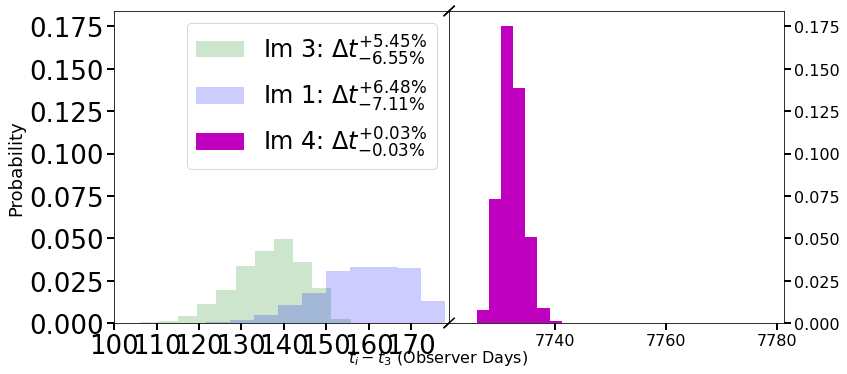

In [32]:
bestMod_cfit=pickle.load(open('lc_modelE_color_constraint_bright.pkl','rb'))
quantile_dict={}
for q in [2.5,16,50,84,97.5]:
    t0, t1,t2,c,M_B = [weighted_quantile(bestMod_cfit.samples[:,i], q/100, 
                                     sample_weight=bestMod_cfit.weights)\
                   for i in range(5)]
    
    quantile_dict['t0_%s'%str(q)]=t0
    quantile_dict['t1_%s'%str(q)]=t1
    quantile_dict['t2_%s'%str(q)]=t2
    quantile_dict['c_%s'%str(q)]=c
    quantile_dict['M_B_%s'%str(q)]=M_B
im2=weighted_quantile(bestMod_cfit.samples[:,1],
                            [.16,.5,.84],sample_weight=bestMod_cfit.weights)
print(im2[0]-im2[1],im2[1],im2[2]-im2[1])
#fig,gs=plot_util.grid_plot(4,8,figsize=(12,12))
fig=plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,8)
ax=fig.add_subplot(gs[-2:,:4])
ax2=fig.add_subplot(gs[-2:,4:],sharey=ax)
#fig,axes=plt.subplots(nrows=1,ncols=2,sharey=True)
#ax=axes[0]
#ax2=axes[1]
temp_lens=models[models['MODEL']==best_model]
#func=scipy.interpolate.interp1d(bestMod_cfit.samples[:,2],bestMod_cfit.weights)
colors=['b','orange','g']
for i in [2,0]:
    quants=weighted_quantile(bestMod_cfit.samples[:,i]-bestMod_cfit.samples[:,1],
                            [.16,.5,.84],sample_weight=bestMod_cfit.weights)
    print(quants[0]-quants[1],quants[1],quants[2]-quants[1])
    ax=plot_util.plot('hist',bestMod_cfit.samples[:,i]-bestMod_cfit.samples[:,1],
                      weights=bestMod_cfit.weights,ax=ax,y_lab='Probability',
                     density=True,bins=25,color=colors[i],ticklabelsize=ticksize,
                    label=r'Im %i: '%(i+1)+'$\Delta t^{+%.2f'%(100*abs((quants[2]-quants[1])/quants[1]))+'\%}'+\
                      '_{-%.2f'%(100*abs((quants[1]-quants[0])/quants[1]))+'\%}$',
                     alpha=.2)
                                      

im4delay=temp_lens['TDELAY'][temp_lens['image']=='SN.4']+\
        (quantile_dict['t0_50']-quantile_dict['t2_50'])

ax2=plot_util.plot('hist',bestMod_cfit.samples[:,1]+im4delay,weights=bestMod_cfit.weights,ax=ax2,ticklabelsize=ticksize,
                     density=True,bins=25,color='m')
quants=weighted_quantile(bestMod_cfit.samples[:,1],
                            [.16,.5,.84],sample_weight=bestMod_cfit.weights)
ax.hist([],color='m',label=r'Im 4: $\Delta t^{+%.2f'%(100*abs((quants[2]-quants[1])/im4delay))+'\%}'+\
                      '_{-%.2f'%(100*abs((quants[1]-quants[0])/im4delay))+'\%}$')

ax2.yaxis.tick_right()
ax2.tick_params(labelsize=16)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()


d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)
ax.legend(fontsize=legend_fontsize)
ax.set_xlim((100,179))
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
fig.text(0.5, 0.08, '$t_i-t_3$ (Observer Days)', ha='center',fontsize=16)
fig.subplots_adjust(wspace=0)
plt.savefig('time_delays_bright.pdf',format='pdf',overwrite=True)
plt.show()

<ipython-input-63-c445a1c6b523>:87: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('full_lightcurve.pdf',format='pdf',overwrite=True)


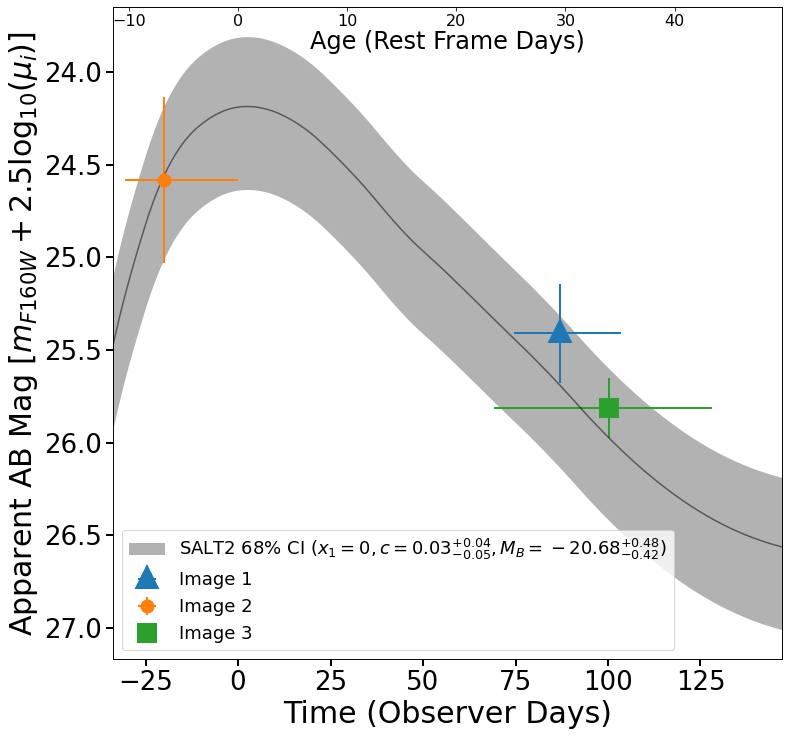

In [63]:

bestMod_cfit=pickle.load(open('lc_modelH_color_constraint.pkl','rb'))

#switch images 1 and 3--combined
# temp_samples=copy.deepcopy(bestMod_cfit.samples)
# temp_samples[:,0]=copy.deepcopy(bestMod_cfit.samples[:,2])
# temp_samples[:,2]=copy.deepcopy(bestMod_cfit.samples[:,0])
# bestMod_cfit.samples=temp_samples
quantile_dict={}
for q in [2.5,16,50,84,97.5]:
    t0, t1,t2,c,M_B = [weighted_quantile(bestMod_cfit.samples[:,i], q/100, 
                                     sample_weight=bestMod_cfit.weights)\
                   for i in range(5)]
    quantile_dict['t0_%s'%str(q)]=t0
    quantile_dict['t1_%s'%str(q)]=t1
    quantile_dict['t2_%s'%str(q)]=t2
    quantile_dict['c_%s'%str(q)]=c
    quantile_dict['M_B_%s'%str(q)]=M_B

band='F160W'
dust = sncosmo.CCM89Dust()
model=sncosmo.Model('salt2-extended',effects=[dust],
                       effect_names=['mw'],
                       effect_frames=['obs'])
model.set(**{'z':1.9459,'mwebv':.014,'t0':0,'x1':0})

best_model='H'

quants=quantile_dict
plot_time=np.arange(model.mintime()+25,model.maxtime(),1)


for q in ['16','50','84']:
    model.set(c=quants['c_'+q])
    model.set_source_peakabsmag(quants['M_B_'+q],'bessellb','ab')
    if q=='50':
        ax=plot_util.plot('plot',plot_time,
            -2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp,
                          fontsize=axis_fontsize,x_lab='Time (Observer Days)',
            y_lab=r'Apparent AB Mag [$m_{'+band+'}+2.5\log_{10}(\mu_i)$]',ticklabelsize=ticksize,
                         color='k',alpha=.5)
    elif q=='16':
        min_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
    else:
        max_cols=-2.5*np.log10(model.bandflux(band,plot_time,zp=zp,zpsys='ab'))+zp
ax.fill_between(plot_time,min_cols,max_cols,color='k',alpha=.3,linewidth=0,
        label='SALT2 68%'+' CI ($x_1=0,c=%.2f^{+%.2f}_{-%.2f},M_B=%.2f^{+%.2f}_{-%.2f}$)'%\
                     (quants['c_50'],quants['c_84']-quants['c_50'],
                            quants['c_50']-quants['c_16'],
                            quants['M_B_50'],
                            quants['M_B_84']-quants['M_B_50'],
                            quants['M_B_50']-quants['M_B_16']))
i=0
points=['^','.','s']
for im in [im0,im1,im2]:
    temp_lens=models[models['MODEL']==best_model]
    mu=temp_lens['MU'][np.where(temp_lens['image']=='SN.'+str(im['id'][0]+1))[0][0]]
    muerr=1.0857*temp_lens['ERR_MU'][temp_lens['image']=='SN.'+str(im['id'][0]+1)]/mu
    b_ind=np.where(im['band']==band.lower())[0][0]
    magerr=1.0857*im['fluxerr'][b_ind]/im['flux'][b_ind]
    mag_err2=np.sqrt(magerr**2+muerr**2)
    mod_mag=-2.5*np.log10(im['flux'][b_ind])+zp+2.5*np.log10(mu)

    #if i==2:
    #    quants=dim_quantile_dict
    most_likely=bestMod_cfit.samples[bestMod_cfit.weights.argmax(),i]
    ax.errorbar(quants['t%i_50'%i],mod_mag,xerr=[[quants['t%i_50'%i]-quants['t%i_16'%i]],
                                                 [quants['t%i_84'%i]-quants['t%i_50'%i]]],
                                                yerr=mag_err2,fmt=points[i],
                    label='Image %i'%(i+1),markersize=12,elinewidth=2,
                    markeredgewidth=8)
#     ax.errorbar(most_likely,mod_mag,xerr=[[quants['t%i_50'%i]-quants['t%i_16'%i]],
#                                                  [quants['t%i_84'%i]-quants['t%i_50'%i]]],
#                                                 yerr=mag_err2,fmt=points[i],
#                     label='Image %i'%(i+1),markersize=12,elinewidth=2,
#                     markeredgewidth=8)

    i+=1
ax.set_xlim((plot_time[0],plot_time[-1]))
ax_main_top=ax.twiny()
ax_main_top.tick_params(direction='in',pad=-22)
ax_main_top.tick_params(labelsize=16)
ax_main_top.set_xlabel('Age (Rest Frame Days)',fontsize=axis_fontsize-6,labelpad=-42)
xlims=ax.get_xlim()
ax_main_top.set_xlim((xlims[0]/2.95,xlims[1]/2.95))
ax.invert_yaxis()
ax.legend(loc='lower left',fontsize=legend_fontsize-6)
plt.savefig('full_lightcurve.pdf',format='pdf',overwrite=True)
plt.show()

<ipython-input-64-687dac37c3d5>:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('full_colorcurve_%s.pdf'%sample,format='pdf',overwrite=True)


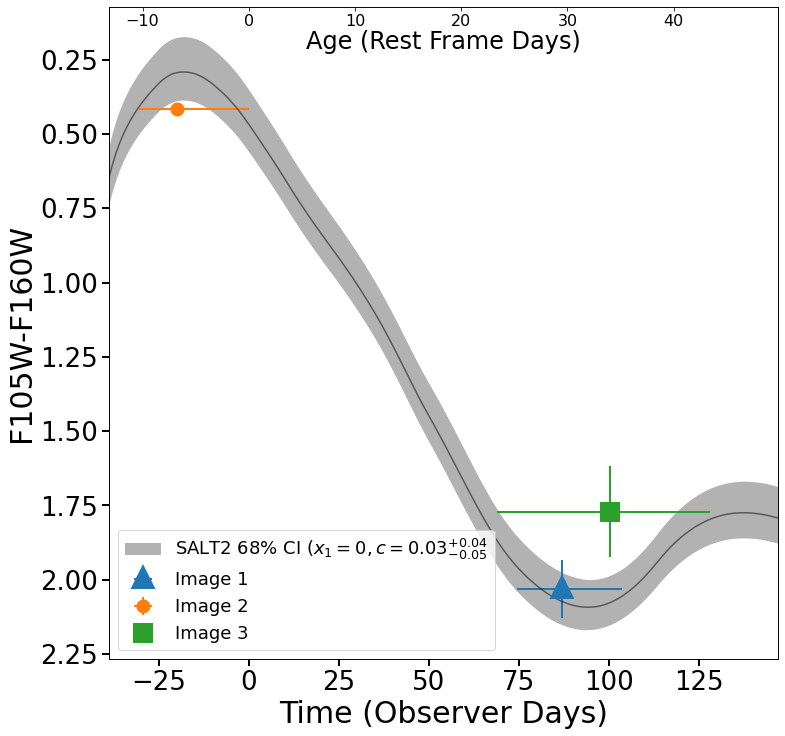

In [64]:
#full color curve
bestMod_cfit=pickle.load(open('lc_modelH_color_constraint.pkl','rb'))
#bestMod_cfit=pickle.load(open('colorcurve_constraint.pkl','rb'))

#switch images 1 and 3--combined
#temp_samples=copy.deepcopy(bestMod_cfit.samples)
#temp_samples[:,0]=copy.deepcopy(bestMod_cfit.samples[:,2])
#temp_samples[:,2]=copy.deepcopy(bestMod_cfit.samples[:,0])
#bestMod_cfit.samples=temp_samples

quantile_dict={}
for q in [2.5,16,50,84,97.5]:
    t0, t1,t2,c,M_B = [weighted_quantile(bestMod_cfit.samples[:,i], q/100, 
                                     sample_weight=bestMod_cfit.weights)\
                   for i in range(5)]
    quantile_dict['t0_%s'%str(q)]=t0
    quantile_dict['t1_%s'%str(q)]=t1
    quantile_dict['t2_%s'%str(q)]=t2
    quantile_dict['c_%s'%str(q)]=c
    quantile_dict['M_B_%s'%str(q)]=M_B
band='F160W'
dust = sncosmo.CCM89Dust()
model=sncosmo.Model('salt2-extended',effects=[dust],
                       effect_names=['mw'],
                       effect_frames=['obs'])
model.set(**{'z':1.9459,'mwebv':.014,'t0':0,'x1':0})

best_model='H'
for sample in ['total']:
    if sample=='bright':
        inds=bright
        quants=bright_quantile_dict
        plot_time=np.arange(model.mintime()+20,model.maxtime(),1)
    elif sample=='dim':
        inds=dim
        quants=dim_quantile_dict
        plot_time=np.arange(model.mintime()+20,model.maxtime()-50,1)
    else:
        quants=quantile_dict
        plot_time=np.arange(model.mintime()+20,model.maxtime(),1)
        
    for q in ['16','50','84']:
        model.set(c=quants['c_'+q])
        if q=='50':
            ax=plot_util.plot('plot',plot_time,
                model.color('F105W','F160W','ab',plot_time),fontsize=axis_fontsize,
                              x_lab='Time (Observer Days)',
                y_lab='F105W-F160W',ticklabelsize=ticksize,
                             color='k',alpha=.5)
        elif q=='16':
            min_cols=model.color('F105W','F160W','ab',plot_time)
        else:
            max_cols=model.color('F105W','F160W','ab',plot_time)
    ax.fill_between(plot_time,min_cols,max_cols,color='k',alpha=.3,linewidth=0,
            label='SALT2 68%'+' CI ($x_1=0,c=%.2f^{+%.2f}_{-%.2f}$'%\
                         (quants['c_50'],quants['c_84']-quants['c_50'],
                                quants['c_50']-quants['c_16']))
    i=0
    points=['^','.','s']
    for im in [im0,im1,im2]:
        temp_color=im['mag'][np.where(im['band']=='f105w')[0][0]]-\
                     im['mag'][np.where(im['band']=='f160w')[0][0]]
        temp_col_err=np.sqrt(np.sum(im['magerr']**2))
    
        #if i==2:
        #    quants=dim_quantile_dict
        most_likely=bestMod_cfit.samples[bestMod_cfit.weights.argmax(),i]
        ax.errorbar(quants['t%i_50'%i],temp_color,xerr=[[quants['t%i_50'%i]-quants['t%i_16'%i]],
                                                     [quants['t%i_84'%i]-quants['t%i_50'%i]]],
                                                    yerr=temp_col_err,fmt=points[i],
                        label='Image %i'%(i+1),markersize=12,elinewidth=2,
                        markeredgewidth=8)
#         ax.errorbar(most_likely,temp_color,xerr=[[quants['t%i_50'%i]-quants['t%i_16'%i]],
#                                                      [quants['t%i_84'%i]-quants['t%i_50'%i]]],
#                                                     yerr=temp_col_err,fmt=points[i],
#                         label='Image %i'%(i+1),markersize=12,elinewidth=2,
#                         markeredgewidth=8)
        
        i+=1
    ax.set_xlim((plot_time[0],plot_time[-1]))
    ax.invert_yaxis()
    ax_main_top=ax.twiny()
    ax_main_top.tick_params(direction='in',pad=-22)
    ax_main_top.tick_params(labelsize=16)
    ax_main_top.set_xlabel('Age (Rest Frame Days)',fontsize=axis_fontsize-6,labelpad=-42)
    xlims=ax.get_xlim()
    ax_main_top.set_xlim((xlims[0]/2.95,xlims[1]/2.95))
    ax.set_xlim(xlims)
    ax.legend(loc='lower left',fontsize=legend_fontsize-6)
    plt.savefig('full_colorcurve_%s.pdf'%sample,format='pdf',overwrite=True)
    plt.show()